<a href="https://colab.research.google.com/github/zjefersound/ai-unoesc/blob/main/data_sci_ml_ai_spam_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Função para carregar imagens como vetores
def load_images_from_folder(folder, label, flatten=False, size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        try:
            img = Image.open(path).convert("RGB").resize(size)
            img_array = (np.asarray(img).flatten() if flatten else np.asarray(img)) / 255.0
            images.append(img_array)
            labels.append(label)
        except:
            continue
    return images, labels


In [3]:
# Carregando imagens
real_imgs, real_labels = load_images_from_folder("dataset/real", label=0)
print(len(real_imgs))

244


In [4]:
fake_imgs, fake_labels = load_images_from_folder("dataset/fake", label=1)
print(len(fake_imgs))

241


In [6]:
X = np.array(real_imgs + fake_imgs)
y = np.array(real_labels + fake_labels)

In [7]:

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Garantir que y esteja no formato categórico
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

In [8]:
# ===============================
# Modelo CNN simples
# ===============================
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinamento
history_cnn = cnn_model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# Avaliação no conjunto de teste
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test_cat)
print(f"Acurácia no teste (CNN simples): {test_accuracy:.2f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5299 - loss: 0.9216 - val_accuracy: 0.6471 - val_loss: 0.6824
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5886 - loss: 0.6704 - val_accuracy: 0.5735 - val_loss: 0.6771
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5942 - loss: 0.6620 - val_accuracy: 0.6765 - val_loss: 0.6459
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7641 - loss: 0.5728 - val_accuracy: 0.6471 - val_loss: 0.5945
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7365 - loss: 0.5258 - val_accuracy: 0.7647 - val_loss: 0.5416
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8344 - loss: 0.4249 - val_accuracy: 0.6471 - val_loss: 0.6974
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8145 - loss: 0.3907 - val_accuracy: 0.7500 - val_loss: 0.5188
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8901 - loss: 0.2979 - val_accuracy: 0.7794 - val_loss: 0.5487
Epoch 9/

In [9]:
# ===============================
# CNN com MobileNetV2
# ===============================
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinamento
history_mobilenet = mobilenet_model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# Avaliação
test_loss, test_accuracy = mobilenet_model.evaluate(X_test, y_test_cat)
print(f"Acurácia no teste (MobileNetV2): {test_accuracy:.2f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 934ms/step - accuracy: 0.4844 - loss: 1.6346 - val_accuracy: 0.5147 - val_loss: 0.8998
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 723ms/step - accuracy: 0.4973 - loss: 1.0018 - val_accuracy: 0.4853 - val_loss: 1.1622
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step - accuracy: 0.5730 - loss: 0.8969 - val_accuracy: 0.5147 - val_loss: 0.9240
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 486ms/step - accuracy: 0.5952 - loss: 0.7937 - val_accuracy: 0.6324 - val_loss: 0.7673
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 672ms/step - accuracy: 0.6107 - loss: 0.7655 - val_accuracy: 0.6471 - val_loss: 0.7307
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 528ms/step - accuracy: 0.6644 - loss: 0.6939 - val_accuracy: 0.6324 - val_loss: 0.7398
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 597ms/step - accuracy: 0.6814 - loss: 0.6345 - val_accuracy: 0.6176 - val_loss: 0.7574
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - accuracy: 0.7458

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step
              precision    recall  f1-score   support

        Real       0.74      0.82      0.78        73
        Fake       0.80      0.71      0.75        73

    accuracy                           0.77       146
   macro avg       0.77      0.77      0.77       146
weighted avg       0.77      0.77      0.77       146



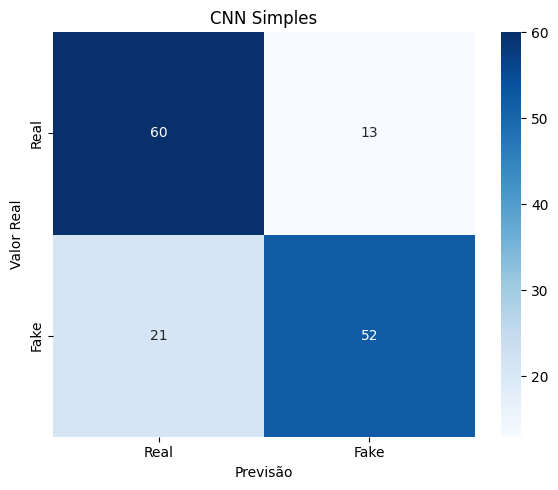

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 732ms/step
              precision    recall  f1-score   support

        Real       0.72      0.86      0.78        73
        Fake       0.83      0.66      0.73        73

    accuracy                           0.76       146
   macro avg       0.77      0.76      0.76       146
weighted avg       0.77      0.76      0.76       146



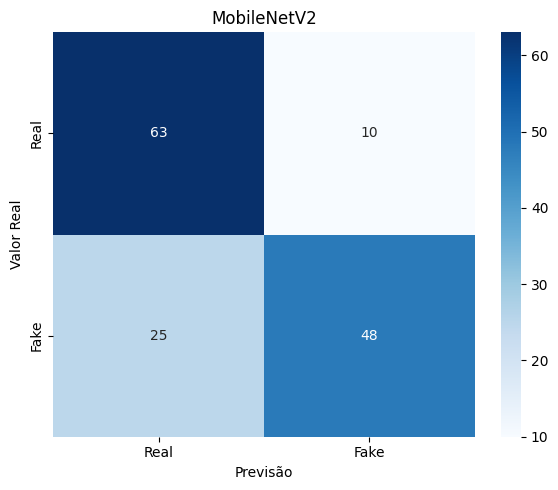

In [10]:
# ===============================
# Matriz de Confusão e Relatório
# ===============================
def plot_confusion(model, X_test, y_test_cat, labels=["Real", "Fake"], title="Matriz de Confusão"):
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=labels))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Previsão")
    plt.ylabel("Valor Real")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Exibir resultados
plot_confusion(cnn_model, X_test, y_test_cat, title="CNN Simples")
plot_confusion(mobilenet_model, X_test, y_test_cat, title="MobileNetV2")



Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6822 - loss: 0.6684 - val_accuracy: 0.6765 - val_loss: 0.6211
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7184 - loss: 0.5394 - val_accuracy: 0.6912 - val_loss: 0.6206
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7012 - loss: 0.5821 - val_accuracy: 0.6765 - val_loss: 0.6156
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 891ms/step - accuracy: 0.7791 - loss: 0.4607 - val_accuracy: 0.6765 - val_loss: 0.6127
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 806ms/step - accuracy: 0.7698 - loss: 0.4737 - val_accuracy: 0.6765 - val_loss: 0.6057
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 871ms/step - accuracy: 0.7973 - loss: 0.4342 - val_accuracy: 0.6765 - val_loss: 0.6016
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7806 - loss: 0.3977 - val_accuracy: 0.6765 - val_loss: 0.5991
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 926ms/step - accuracy: 0.8569 - loss: 0.3571 - val_accuracy: 0.6765 - val_loss: 0.5910
E

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 848ms/step
              precision    recall  f1-score   support

        Real       0.75      0.93      0.83        73
        Fake       0.91      0.68      0.78        73

    accuracy                           0.81       146
   macro avg       0.83      0.81      0.81       146
weighted avg       0.83      0.81      0.81       146



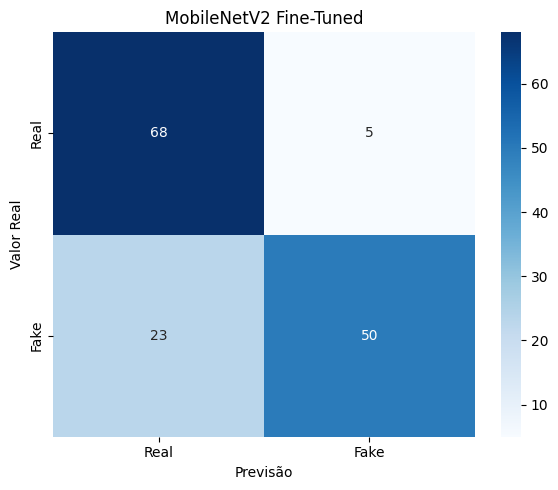

In [11]:
# ===============================
# Fine-tuning MobileNetV2
# ===============================
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = mobilenet_model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

test_loss, test_accuracy = mobilenet_model.evaluate(X_test, y_test_cat)
print(f"Acurácia no teste (MobileNetV2 fine-tuned): {test_accuracy:.2f}")

plot_confusion(mobilenet_model, X_test, y_test_cat, title="MobileNetV2 Fine-Tuned")